In [2]:
import json
import gzip
import torch
import torchvision.transforms as transforms
import urllib
from PIL import Image
import torchvision.models as models


In [3]:
import warnings

# Filter out DeprecationWarning related to sampling from a set
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
def read_json_from_zip(zip_file_path):
    data = []
    with gzip.open(zip_file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

In [5]:
# Function to read JSON data from the file
def read_json_file(json_file_path):
    data = []
    with open(json_file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

Fetching Data

In [6]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# zip_file_path = '/content/drive/MyDrive/Colab Notebooks/final_data/meta_AMAZON_FASHION.json.gz'
# meta = read_json_from_zip(zip_file_path)

# zip_file_path = '/content/drive/MyDrive/Colab Notebooks/final_data/AMAZON_FASHION.json.gz'
# rev = read_json_from_zip(zip_file_path)

In [7]:
zip_file_path = 'Datasets/meta_AMAZON_FASHION.json.gz'
meta = read_json_from_zip(zip_file_path)

zip_file_path = 'Datasets/AMAZON_FASHION.json.gz'
rev = read_json_from_zip(zip_file_path)

In [8]:
# Convert each JSON object into a dictionary
metadata = [{key: value for key, value in item.items()} for item in meta]

In [9]:
# Convert each JSON object into a dictionary
reviews = [{key: value for key, value in item.items()} for item in rev]

In [10]:
item_image_detail = {}

for item in metadata:
    itemid = item['asin']
    image_urls = item.get('imageURLHighRes', [])
    if isinstance(image_urls, list) and image_urls:
        imageurl = image_urls[0]
    else:
        imageurl = None

    description = item.get('description', [])
    details = item.get('details', '')
    title = item.get('title', '')

    # Convert description list to string
    description_str = ' '.join(description) if isinstance(description, list) else str(description)

    if not any([description_str, details, title]):
        itemdetail = None
    else:
        # Concatenate description, details, and title strings
        itemdetail = description_str + ' ' + details + ' ' + title
    item_image_detail[itemid] = [imageurl, itemdetail]



In [11]:
training_data = []

for review_data in reviews:
    userid = review_data['reviewerID']
    itemid = review_data['asin']
    review = review_data.get('reviewText', '')
    summary = review_data.get('summary', '')
    ratingg = review_data.get('overall', None)  # Get the overall rating

    if not any([review, summary]) or ratingg is None:  # Check if review, summary, or ratingg is None
        summ = None
    else:
        summ = review + ' ' + summary

    # Get image details from item_image_detail dictionary using itemid as key
    image_details = item_image_detail.get(itemid, [None, None])

    # Check if all values are not None
    if all([userid, itemid, ratingg, image_details[0], image_details[1], summ]):
        # Append all values to the data list
        data = [userid, itemid, ratingg, image_details[0], image_details[1], summ]
        training_data.append(data)

# Now, training_data contains the processed data with non-None values for userid, itemid, image details, summary, and rating

In [12]:
from collections import Counter

# Count the occurrences of each user ID
user_counts = Counter(data[0] for data in training_data)

# Sort training_data based on the count of user occurrences in descending order
sorted_training_data = sorted(training_data, key=lambda x: user_counts[x[0]], reverse=True)

# # Print the first 10 lists in sorted_training_data
# for i, data in enumerate(sorted_training_data[:50], 1):
#     print(f"{i}: {data}")

training_data = sorted_training_data

In [13]:
# Uncomment this cell to run in colab and comment the below cell

# representations = []

# loaded_representations = torch.load('/content/image_representations_10.pt')

# for rep in loaded_representations:
#     representations.append(rep)

In [14]:
# Initialize an empty set to store unique userids
unique_users = set()

# Iterate over the first 10000 rows in the training_data
for data in training_data[:10000]:
    # Extract the userid from the current row and add it to the set
    userid = data[0]
    unique_users.add(userid)

# Convert the set of unique userids to a list
unique_userids = list(unique_users)

# Print the list of unique userids
print(len(unique_userids))


1403


In [15]:
image_url_dict = {}

# Iterate through the first 10000 rows of training_data
for data in training_data[:10000]:
    item_id = data[1]  # Extract item ID
    image_url = data[3]  # Extract image URL from training_data (assuming it's at index 3)

    # Add item ID and image URL to the dictionary
    image_url_dict[item_id] = image_url

In [16]:
representations = []

loaded_representations = torch.load('image_representations_10.pt')

for rep in loaded_representations:
    representations.append(rep)

In [17]:
ini_user_rep = {}
freq = {}

for data in training_data[:10000]:
    userid = data[0]
    freq[userid] = 0
    ini_user_rep[userid] = torch.zeros((1,16))

In [18]:
for i in range(10000):
    id = training_data[i][0]
    prev = ini_user_rep[id]*freq[id]
    ad = torch.sum(representations[i],dim=1)
    new = prev + ad*training_data[i][2]
    freq[id] +=1
    new = new/freq[id]
    ini_user_rep[id] = new

In [19]:
# Function to preprocess text
import string

def preprocess_text(text):
    if text is None:
        return []
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    return tokens


index = 1
word_to_index = {}
def create_word_to_index_dict(text):
    global index
    text = preprocess_text(text)
    for word in text:
        if word not in word_to_index.keys():
            word_to_index[word]=index
            index+=1



In [20]:
for i in range(10000):
  create_word_to_index_dict(training_data[i][4])
  create_word_to_index_dict(training_data[i][5])

In [21]:
len(word_to_index)

22957

Encoders


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, num_heads, hidden_size, dropout):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size)
        encoder_layer = nn.TransformerEncoderLayer(embed_size, num_heads, hidden_size, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_size, embed_size)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.fc(x))
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


In [23]:
vocab_size = 23000
embed_size = 16
num_layers = 2
num_heads = 4
hidden_size = 64
dropout = 0.1

encoder_review = TransformerEncoder(vocab_size, embed_size, num_layers, num_heads, hidden_size, dropout)
encoder_itemrep = TransformerEncoder(vocab_size, embed_size, num_layers, num_heads, hidden_size, dropout)


### Image Representation

In [24]:
# import requests
# import matplotlib.pyplot as plt
# from PIL import Image
# from io import BytesIO

# def show_image_from_url(image_url):
#     response = requests.get(image_url)
#     img = Image.open(BytesIO(response.content))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()

# # Example usage
# image_url = 'https://images-na.ssl-images-amazon.com/images/I/4196%2BTu5T%2BL.jpg'
# show_image_from_url(image_url)

In [25]:
# # VGG CODE

# import torch
# import torchvision.transforms as transforms
# import urllib
# from PIL import Image
# import torchvision.models as models

# # Load the pre-trained VGG model
# vgg_model = models.vgg16(pretrained=True)
# # Remove the classification layer (fc8) to obtain feature representation
# vgg_model.classifier = torch.nn.Sequential(*list(vgg_model.classifier.children())[:-3])

# # Change the output size of the added linear layer to match the new representation size
# vgg_model.classifier.add_module('fc8', torch.nn.Linear(4096, 16))

# # Define preprocessing transforms
# preprocess = transforms.Compose([
#     transforms.Resize((224, 224)),  # VGG model expects images of size 224x224
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
# ])

# # Function to get image tensor from URL
# def image_from_url(url):
#     try:
#         with urllib.request.urlopen(url) as url_response:
#             image = Image.open(url_response).convert('RGB')
#             return image
#     except Exception as e:
#         print("Error loading image from URL:", e)
#         return None

# # Function to divide the image into 16 regions, preprocess each region, and get representations
# def get_image_representation(image_url):
#     image = image_from_url(image_url)
#     if image is not None:
#         regions_representation = []
#         width, height = image.size
#         # Define the size of each region
#         region_size = (width // 4, height // 4)
#         for i in range(4):
#             for j in range(4):
#                 # Crop the region
#                 left = j * region_size[0]
#                 top = i * region_size[1]
#                 right = left + region_size[0]
#                 bottom = top + region_size[1]
#                 region = image.crop((left, top, right, bottom))
#                 # Preprocess the region
#                 region = preprocess(region).unsqueeze(0)  # Add batch dimension
#                 # Get representation for the region
#                 with torch.no_grad():
#                     features = vgg_model(region)
#                     regions_representation.append(features.squeeze().unsqueeze(0))  # Add as tensor and unsqueeze for batch dimension
#         # Concatenate representations of all regions along the batch dimension
#         return torch.cat(regions_representation, dim=0).unsqueeze(0)  # Unsqueze for batch dimension


In [26]:
import torch
import torch.nn as nn

class NN_rating_alpha(nn.Module):
    def __init__(self):
        super(NN_rating_alpha, self).__init__()
        self.hidden_layer = nn.Linear(16, 16)
        self.output_layer = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        x = torch.sigmoid(self.output_layer(x))
        return x


In [27]:
ratingpredict = NN_rating_alpha()
NN_alpha = NN_rating_alpha()

In [28]:
import torch
import torch.nn as nn

class NN_Userrep(nn.Module):
    def __init__(self):
        super(NN_Userrep, self).__init__()
        self.hidden_layer = nn.Linear(16, 16)
        self.output_layer = nn.Linear(16, 16)

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        x = torch.sigmoid(self.output_layer(x))
        return x


In [29]:
userrepp = NN_Userrep()

In [30]:
# def preprocess_text2(text):
#     text = preprocess_text(text)
#     indices = [word_to_index[word] for word in text]
#     return indices

In [31]:
def preprocess_text2(text):
    text = preprocess_text(text)
    indices = [word_to_index.get(word, len(word_to_index) + 1) for word in text]
    return indices

In [32]:
import torch
import torch.optim as optim

loss_fn = torch.nn.MSELoss()
optimizer = optim.SGD([{'params': userrepp.parameters()},
                       {'params': encoder_review.parameters()},
                       {'params': encoder_itemrep.parameters()},
                       {'params': NN_alpha.parameters()},
                       {'params': ratingpredict.parameters()}], lr=0.01)

In [33]:
def predict_rat(review, item_detail, ini_userrep, image_rep):
    final_user_rep = userrepp(ini_userrep)
    reviewrep = encoder_review(review)
    # print(reviewrep)
    itemrep = encoder_itemrep(item_detail)
    inp1 = torch.mul(final_user_rep,reviewrep)
    inp1 = inp1.expand(image_rep.shape[1], -1)
    inp1 = torch.mul(inp1, image_rep)
    inp1 = inp1.view(4, 16)
    alphs = NN_alpha(inp1)
    tot = torch.sum(alphs)
    alphs= alphs.expand(4,16)
    alphs= alphs.view(1,4,16)
    wimage_rep=torch.mul(alphs,image_rep)
    wimage_rep=torch.sum(wimage_rep,dim=1)
    wimage_rep/=tot
    inp2 = torch.mul(wimage_rep,final_user_rep)
    inp2 = torch.mul(inp2,itemrep)
    predicted_rating = ratingpredict(inp2)
    return predicted_rating


In [34]:
for i in range(10000):
    true_rat = torch.tensor(training_data[i][2])
    true_rat = true_rat.view(1, 1)
    ve1 = preprocess_text2(training_data[i][5])
    ve2 = preprocess_text2(training_data[i][4])
    ve1 = torch.tensor(ve1).unsqueeze(0)
    ve2 = torch.tensor(ve2).unsqueeze(0)
    predicted_rating = predict_rat(ve1,ve2,ini_user_rep[training_data[i][0]],representations[i])
    loss = loss_fn(predicted_rating, true_rat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [35]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def show_image_from_url(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [36]:
# For an existing user, call this function

def get_top_recommendations(userid, review_text):
    processed_review = preprocess_text2(review_text)
    processed_review = torch.tensor(processed_review).unsqueeze(0)
    recommendations = []
    rated_items = set()
    
    for data in training_data[:10000]:
        if data[0] == userid:
            rated_items.add(data[1])
    
    for i, data in enumerate(training_data[:10000]):
        itemid = data[1]
        if itemid not in rated_items:
            item_detail = preprocess_text2(data[4])
            item_detail = torch.tensor(item_detail).unsqueeze(0)
            predicted_rating = predict_rat(processed_review, item_detail, ini_user_rep[userid], representations[i])
            recommendations.append((itemid, predicted_rating, training_data[i][3]))
        
    recommendations.sort(key=lambda x: x[1], reverse=True)
    for item in recommendations[:5]:
        show_image_from_url(item[2])
    
    return recommendations[:5]

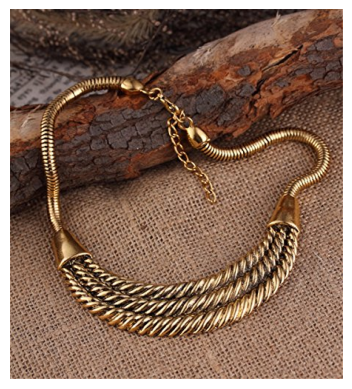

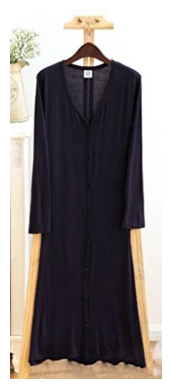

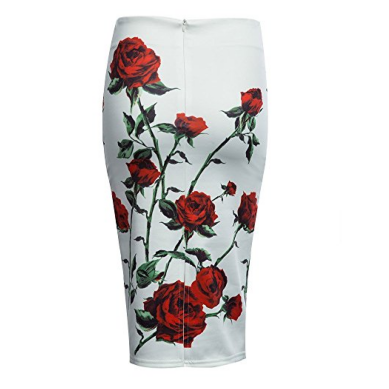

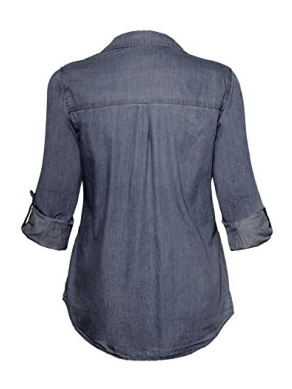

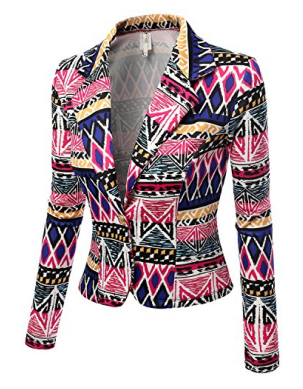

[('B00KW4L9XQ',
  tensor([[1.]], grad_fn=<SigmoidBackward0>),
  'https://images-na.ssl-images-amazon.com/images/I/61AyJ-%2BeZpL.jpg'),
 ('B00NIPAIFG',
  tensor([[1.]], grad_fn=<SigmoidBackward0>),
  'https://images-na.ssl-images-amazon.com/images/I/31G8ybUD9bL.jpg'),
 ('B01FO04LGE',
  tensor([[1.]], grad_fn=<SigmoidBackward0>),
  'https://images-na.ssl-images-amazon.com/images/I/51rl-hl%2Bk4L.jpg'),
 ('B01H4105JS',
  tensor([[1.]], grad_fn=<SigmoidBackward0>),
  'https://images-na.ssl-images-amazon.com/images/I/411r%2BBDsLjL.jpg'),
 ('B00L2W2FOE',
  tensor([[1.]], grad_fn=<SigmoidBackward0>),
  'https://images-na.ssl-images-amazon.com/images/I/61llcvYEd7L.jpg')]

In [37]:
get_top_recommendations(unique_userids[255], 'Golden Chains')

In [38]:

# Create a dictionary to store running sum and count for each item_id
average_ratings = {}
for i, data in enumerate(training_data[:10000]):
    item_id = data[1]
    rating = data[2]
    if item_id in average_ratings:
        # Update running sum and count
        sum_rating, count = average_ratings[item_id]
        sum_rating += rating
        count += 1
        average_ratings[item_id] = (sum_rating, count)
    else:
        # Initialize running sum and count for new item_id
        average_ratings[item_id] = (rating, 1)

# Calculate running average for each item_id
for item_id, (sum_rating, count) in average_ratings.items():
    average_ratings[item_id] = sum_rating / count

In [39]:
import random

# For a new user, recommend any 5 items randomly from the top rated items in the data set.
def get_top_recommendations_for_new_user():
    # Sort items by average rating in descending order
    sorted_items = sorted(average_ratings.items(), key=lambda x: x[1], reverse=True)
    
    # Get top rated items with a rating of 5
    top_items = [item[0] for item in sorted_items if item[1] == 5]

    # Shuffle the list of top rated items
    random.shuffle(top_items)

    # Get any 5 items from the shuffled list
    recommended_items = top_items[:5]
    for item in recommended_items:
        show_image_from_url(image_url_dict[item])

    # Return the recommended items
    return recommended_items


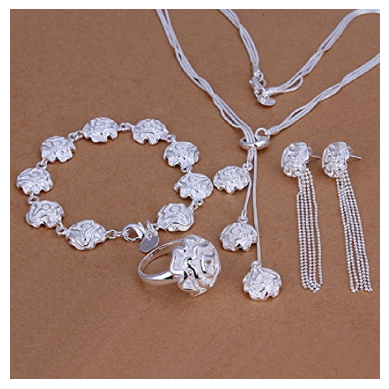

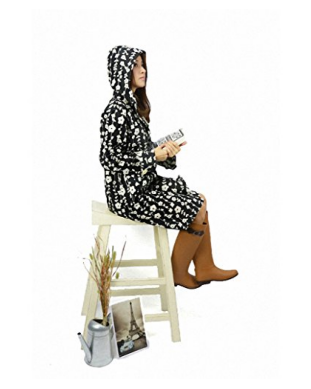

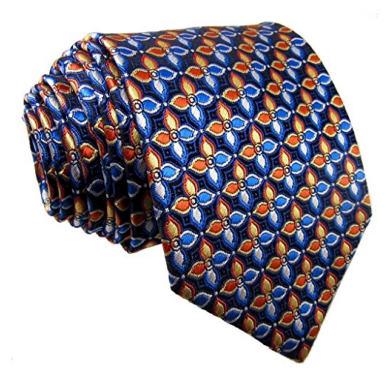

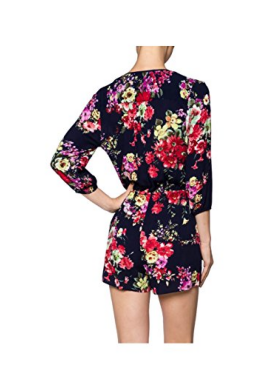

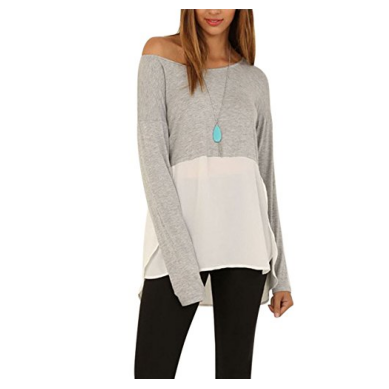

['B00M1D5AOU', 'B00NOIS3IG', 'B00QAFTA2S', 'B00W2IANO6', 'B01H1T35G8']

In [46]:
get_top_recommendations_for_new_user()